In [1]:
SEED_EXPERIMENT=0

In [2]:
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import models

import pytorch_lightning as pl

from transforms.transform import base_transform, augmented_transform, IdentityTransform

from models.encoders import get_resnet18_encoder, get_shufflenetv2_encoder, get_alexnet_encoder, SpectrumCNN

from models.lit_models import CNN_classifier
import os
import random

from models.utils import load_model
import easygui


os.environ['PYTHONHASHSEED'] = str(SEED_EXPERIMENT)
# Torch RNG
torch.manual_seed(SEED_EXPERIMENT)
torch.cuda.manual_seed(SEED_EXPERIMENT)
torch.cuda.manual_seed_all(SEED_EXPERIMENT)
# Python RNG
np.random.seed(SEED_EXPERIMENT)
random.seed(SEED_EXPERIMENT)

batch_size = 64

# 1. DATASET

## choose dataset!

In [3]:
train_dataset = torchvision.datasets.ImageFolder('data/images_amp_phase/train', transform=augmented_transform)
test_dataset = torchvision.datasets.ImageFolder('data/images_amp_phase/test', transform=base_transform)

In [3]:
train_dataset = torchvision.datasets.ImageFolder('data/images_spectrogram/train', transform=augmented_transform)
test_dataset = torchvision.datasets.ImageFolder('data/images_spectrogram/test', transform=base_transform)

## make dataloader

In [4]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=1)
val_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size, num_workers=1)

# 2. Choose model

In [5]:
MODEL_NAME="RESNET_18"
encoder = get_resnet18_encoder()

In [5]:
MODEL_NAME="SHUFFLENET"
encoder = get_shufflenetv2_encoder()

In [5]:
MODEL_NAME="ALEXNET"
encoder = get_alexnet_encoder()

In [5]:
MODEL_NAME="SPECTRUM_CNN"
encoder=SpectrumCNN()

### load pretrained weights (for simsiam representation)

In [6]:
encoder, _ = load_model(save_path=easygui.fileopenbox(msg="Choose a model",
                                                      default="./pretrained_encoders/*.pth"),
                        model=encoder)

# 3. Run classification!

In [7]:
lit_model = CNN_classifier(encoder=encoder)

In [8]:
train_dataloader.dataset.root

'data/images_spectrogram/train'

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/shstan/anaconda3/envs/pytorch_base/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:118: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shstan/anaconda3/envs/pytorch_base/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Finding best initial lr:  86%|████████▌ | 86/100 [00:02<00:00, 31.59it/s]
LR finder stopped early after 86 steps due to diverging

[epoch_avg_train_loss=2161911.64093]


/tmp/ipykernel_471024/4133287456.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


1.0964781961431852e-05


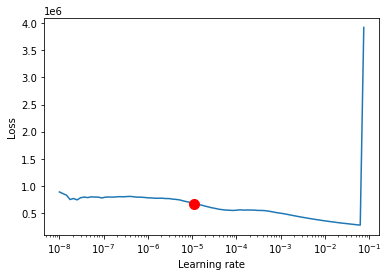

In [9]:
trainer = pl.Trainer(
    auto_lr_find=True,
    gpus=1, max_epochs=20,
    enable_checkpointing=True,
    log_every_n_steps=10,
    amp_backend="native",
    num_sanity_val_steps=0
)
# Run learning rate finder
lr_finder = trainer.tuner.lr_find(lit_model, train_dataloaders=train_dataloader)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()
print(lr_finder.suggestion())

In [10]:
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update hparams of the model
lit_model.hparams.lr = new_lr

# Fit model
trainer.fit(lit_model,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | encoder   | SpectrumCNN       | 5.8 M 
1 | fc        | Sequential        | 263 K 
2 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
6.1 M     Trainable params
0         Non-trainable params
6.1 M     Total params
24.245    Total estimated model params size (MB)
/home/shstan/anaconda3/envs/pytorch_base/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/shstan/anaconda3/envs/pytorch_base/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader

Epoch 0: 100%|█████████▉| 1437/1438 [00:43<00:00, 33.37it/s, loss=0.466, v_num=25][epoch_avg_val_loss=0.51505, VAL_ROC_AUC=0.78577, VAL_F1=0.90915, VAL_Accuracy=0.85217]
best_stat: [epoch_avg_val_loss=0.51505(epoch:0), VAL_ROC_AUC=0.78577(epoch:0), VAL_F1=0.90915(epoch:0), VAL_Accuracy=0.85217(epoch:0)]
Epoch 1: 100%|█████████▉| 1436/1438 [00:42<00:00, 33.45it/s, loss=0.461, v_num=25][epoch_avg_val_loss=0.55395, VAL_ROC_AUC=0.78990, VAL_F1=0.88854, VAL_Accuracy=0.82991]
best_stat: [epoch_avg_val_loss=0.51505(epoch:0), VAL_ROC_AUC=0.78990(epoch:1), VAL_F1=0.90915(epoch:0), VAL_Accuracy=0.85217(epoch:0)]
Epoch 2: 100%|█████████▉| 1435/1438 [00:43<00:00, 33.09it/s, loss=0.444, v_num=25][epoch_avg_val_loss=0.99176, VAL_ROC_AUC=0.77715, VAL_F1=0.04255, VAL_Accuracy=0.25255]
best_stat: [epoch_avg_val_loss=0.51505(epoch:0), VAL_ROC_AUC=0.78990(epoch:1), VAL_F1=0.90915(epoch:0), VAL_Accuracy=0.85217(epoch:0)]
Epoch 3: 100%|█████████▉| 1435/1438 [00:43<00:00, 33.17it/s, loss=0.414, v_num=25][ep

## classification results
- ResNet18, without pretraining(9, 10):
    - amp(lr=0.0003019951720402019)=[epoch_avg_val_loss=0.02005(epoch:18), VAL_ROC_AUC=0.99914(epoch:18), VAL_F1=0.99661(epoch:18), VAL_Accuracy=0.99418(epoch:18)] (42m 5.3s)
    - spec(lr=0.0002089296130854041)=[epoch_avg_val_loss=0.03713(epoch:16), VAL_ROC_AUC=0.99880(epoch:16), VAL_F1=0.99089(epoch:16), VAL_Accuracy=0.98624(epoch:16)] (61m 56.8s)
- ResNet18, with pretraining(11, 12):
    - amp(lr=0.00012022644346174131)=[epoch_avg_val_loss=0.01928(epoch:17), VAL_ROC_AUC=0.99927(epoch:17), VAL_F1=0.99672(epoch:18), VAL_Accuracy=0.99437(epoch:18)] (44m 17.5s)
    - spec(lr=3.311311214825911e-05)=[epoch_avg_val_loss=0.03352(epoch:16), VAL_ROC_AUC=0.99894(epoch:16), VAL_F1=0.99151(epoch:18), VAL_Accuracy=0.98715(epoch:18)] (60m 10.5s)

- ShuffleNetV2, without pretraining(13, 14):
    - amp(lr=0.002754228703338169)=[epoch_avg_val_loss=0.01603(epoch:19), VAL_ROC_AUC=0.99947(epoch:19), VAL_F1=0.99716(epoch:18), VAL_Accuracy=0.99513(epoch:18)] (24m 18.2s)
    - spec(lr=0.003311311214825908)=[epoch_avg_val_loss=0.03222(epoch:19), VAL_ROC_AUC=0.99901(epoch:19), VAL_F1=0.99206(epoch:16), VAL_Accuracy=0.98798(epoch:16)] (34m 1.6s)
- ShuffleNetV2, with pretraining(15, 16):
    - amp(lr=0.0001445439770745928)=[epoch_avg_val_loss=0.01390(epoch:18), VAL_ROC_AUC=0.99963(epoch:14), VAL_F1=0.99764(epoch:18), VAL_Accuracy=0.99596(epoch:18)] (23m 56.5s)
    - spec(lr=4.786300923226383e-07)=[epoch_avg_val_loss=0.03254(epoch:17), VAL_ROC_AUC=0.99898(epoch:17), VAL_F1=0.99199(epoch:17), VAL_Accuracy=0.98789(epoch:17)] (33m 26.4s)

- AlexNet, without pretraining(17, 20):
    - amp(lr=8.317637711026709e-05)=[epoch_avg_val_loss=0.05086(epoch:18), VAL_ROC_AUC=0.99231(epoch:18), VAL_F1=0.99244(epoch:18), VAL_Accuracy=0.98699(epoch:18)] (19m 54.1s)
    - spec(lr=5.7543993733715664e-05)=[epoch_avg_val_loss=0.05664(epoch:18), VAL_ROC_AUC=0.99713(epoch:19), VAL_F1=0.98683(epoch:18), VAL_Accuracy=0.98004(epoch:18)] (28m 12.8s)
- AlexNet, with pretraining(21, N/A):
    - amp(lr=7.585775750291837e-08)=[epoch_avg_val_loss=0.07693(epoch:17), VAL_ROC_AUC=0.98858(epoch:8), VAL_F1=0.99026(epoch:8), VAL_Accuracy=0.98319(epoch:8)] (20m 22.6s)
    - spec(lr=1.0964781961431852e-05)= failed due to weights being incorrectly initialized by SimSiam Training(29m 5.2s) # currently running

- SpectrumCNN, without pretraining(22, 23):
    - amp(lr=0.0001445439770745928)=[epoch_avg_val_loss=0.06133(epoch:19), VAL_ROC_AUC=0.99146(epoch:13), VAL_F1=0.99076(epoch:13), VAL_Accuracy=0.98408(epoch:13)] (12m 0.9s)
    - spec(lr=0.0007585775750291836)=[epoch_avg_val_loss=0.07264(epoch:7), VAL_ROC_AUC=0.99485(epoch:7), VAL_F1=0.98507(epoch:19), VAL_Accuracy=0.97746(epoch:19)] (15m 7.5s)
- SpectrumCNN, with pretraining(24, 25):
    - amp(lr=3.311311214825911e-05)=[epoch_avg_val_loss=0.16220(epoch:6), VAL_ROC_AUC=0.94823(epoch:18), VAL_F1=0.97374(epoch:6), VAL_Accuracy=0.95436(epoch:6)] (11m 57.9s)
    - spec(lr=1.0964781961431852e-05)=[epoch_avg_val_loss=0.39398(epoch:5), VAL_ROC_AUC=0.82363(epoch:5), VAL_F1=0.91594(epoch:5), VAL_Accuracy=0.86345(epoch:5)] (14m 41.3s)
